# Análise geo espacial

```shell
$ pip install ipyleaflet
$ jupyter nbextension enable --py --sys-prefix ipyleaflet
```

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

from datetime import datetime

from IPython.display import display, Latex, Math, Markdown
# from ipyleaflet import Map, basemaps, basemap_to_tiles

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import math
import pytz
import shutil
import pandas as pd

try:
    sc = SparkContext('local[*]')
    sc.setLogLevel("OFF")
    
except ValueError:
    # Prevent the notebook to crash if this block is executed more then once
    pass

spark = SparkSession(sc)

In [2]:
gps = spark.read.parquet("./data/ds/gps-log.parquet")
occupation = spark.read.parquet("./data/ds/occupation.parquet")

In [3]:
def save_csv(df, name):
    try:
        shutil.rmtree("./data/ds/%s" % name)
    except FileNotFoundError:
        pass
    df.coalesce(1).write.csv("./data/ds/%s" % name, header='true')

In [4]:
# gps.filter(col("date") == "2017-12-06").select("lat","long","speed","timestamp", "datetime").show()
# occupation.filter(col("timestamp") >= "2017-12-06").orderBy("timestamp").show()

next_col = Window.partitionBy("date").orderBy("timestamp").rowsBetween(Window.currentRow, 1)

avg_ride = Window.partitionBy("o.timestamp").orderBy("o.timestamp")

o = (
    occupation.alias("o")
    .withColumn("nextTimestamp", max("timestamp").over(next_col))
)

data = (
    gps.alias("g")
    .withColumn("kmh", col("speed") * 3.6)
    .join(
        o,
        (col("g.timestamp").cast("long") >= col("o.timestamp").cast("long")) &
        (col("g.timestamp").cast("long") <= col("nextTimestamp").cast("long")),
        "right"
    )
    .drop("nextTimestamp")
#     .filter(col("o.date") != "12/12/2017")
    .filter(col("g.timestamp").isNotNull() & col("lat").isNotNull() & col("long").isNotNull())
    .select(
        "o.date",
        col("g.timestamp").cast("long").alias("unix_timestamp"),
        col("g.timestamp").alias("timestamp"),
        col("wifi_occupation").alias("wifi"), 
        col("real_occupation").alias("real"), 
        "o.direction",
        "kmh",
        "g.lat", 
        "g.long"
    )
    .dropDuplicates(["unix_timestamp"])
    .orderBy("unix_timestamp", "lat", "long")
)

# save_csv(data, "occupation-gps-log.csv")

data.toPandas()

,date,unix_timestamp,timestamp,wifi,real,direction,kmh,lat,long
0,06/12/2017,1512587160,2017-12-06 19:06:00,2,1,0,35.4168,-23.652033,-46.705589
1,06/12/2017,1512587161,2017-12-06 19:06:01,2,1,0,36.3096,-23.651958,-46.705533
2,06/12/2017,1512587162,2017-12-06 19:06:02,2,1,0,36.7632,-23.651880,-46.705480
3,06/12/2017,1512587163,2017-12-06 19:06:03,2,1,0,38.0124,-23.651797,-46.705423
4,06/12/2017,1512587164,2017-12-06 19:06:04,2,1,0,36.9972,-23.651724,-46.705360
5,06/12/2017,1512587165,2017-12-06 19:06:05,2,1,0,39.1320,-23.651643,-46.705305
6,06/12/2017,1512587166,2017-12-06 19:06:06,2,1,0,40.9428,-23.651558,-46.705243
7,06/12/2017,1512587167,2017-12-06 19:06:07,2,1,0,41.1912,-23.651475,-46.705182
8,06/12/2017,1512587168,2017-12-06 19:06:08,2,1,0,41.9724,-23.651389,-46.705118
9,06/12/2017,1512587169,2017-12-06 19:06:09,2,1,0,42.1164,-23.651299,-46.705057


In [19]:
data.select('real').distinct().show()

+----+
|real|
+----+
|   1|
|   6|
|   3|
|   5|
|   4|
|   8|
|   2|
+----+



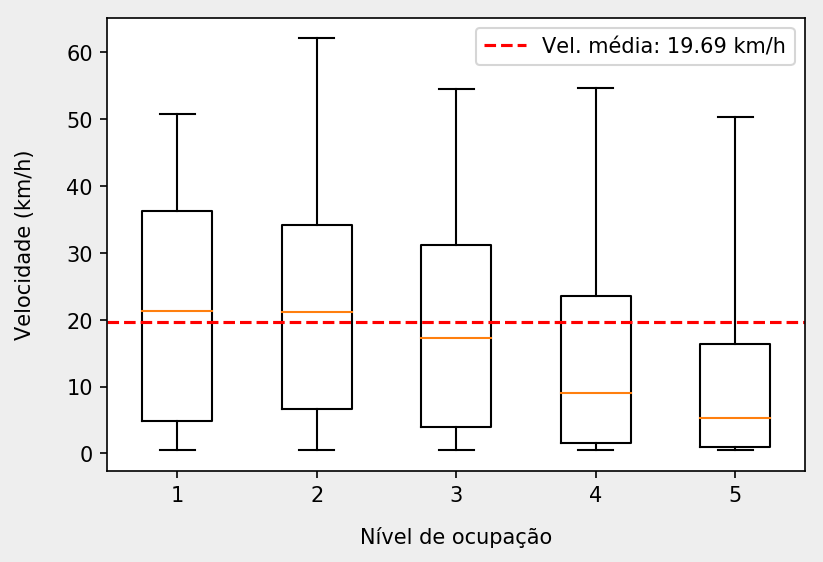

In [35]:
d = data.filter(col('kmh') > 0.5).toPandas()
m = d['kmh'].mean()
g = d.groupby('wifi')['kmh']

fig, ax = plt.subplots(dpi=150, figsize=(6, 4), facecolor="#eeeeee")

ax.boxplot([g.get_group(i).values for i in [1,2,3,4,5]], whis='range')
ax.set_ylabel("Velocidade (km/h)", labelpad=15)
ax.set_xlabel("Nível de ocupação", labelpad=10)
# ax.annotate("%.2f km/h" % m,   xy=(6.3, m + 2))
mean_line = plt.axhline(m, color='r', linestyle='--')
plt.legend([mean_line], ["Vel. média: %.2f km/h" % m])
plt.show()

# Entre-picos


**Produtos da dissertação**
- Documentação do Software
- Mapa de carregamento
- 

**Artigo**
- Método de ocupação de janela deslizante
    - Resultados estatísticos
- Mapa de temperatura
    - Carregamento por trecho
    - Principais pontos
- Velocidade / Ocupação